In this notebook we illustrate how **one-cycle learning rate & momentum training with annealing** is performed in our experiments, write the script to train in a range of (small) training samples and plot the results of this script.

## How is it organized?

1. In the first section notebook we illustrate the scenario were ImageNet is used with gradual unfreezing for the whole dataset. This is useful to test how the model behaves when all the data is available. 

2. In the second section the script is written and we explore different alternatives in transfer learning for a range of training data. We do so by combining regular training with multiple alternatives in transfer learning:

    * Is transfer learning used? If so, from what dataset?  We contemplate ImageNet and MURA (general and medical images respectively).
    * How is transfer learning done? previous CNN as feature extractor, fine-tune CNN? If we fine-tune, do we use differential learning rates?
    * Do we do progressive unfreezing?

 Some of those options are excluding and other are complementary. For instance, no transfer learning and using the previous CNN as feature extractor are excluding.

3. In the last section we plot the results of running the script.

## I want to dig deeper

This notebook's main purpose is illustrating how one-cycle learning rate & momentum training with annealing is used. All other aspects are imported from `data_manipulation`,`utils`, `architectures` and `train_functions`. If the reader wants to dig dipper in aspects such as how data augmentation is implemented, what policy we use for the learning rate or how the optimizer is used we point them to the modules mentioned above. 



# Using all the available data
## Imports & global variables

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import sys; sys.path.append("../../..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder

BATCH_SIZE = 16
EPOCHS = 8
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
PRETRAINED = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = '14diseases'


BASE_PATH = Path('../../../..')
PATH = BASE_PATH/'data'
SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/models'
IMG_FOLDER = PATH/'ChestXRay-250'


# MURA Pretrained

# Data Batches

In [4]:
# data preparation
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")


train_dl = DataBatches(train_df, img_folder_path=IMG_FOLDER,transforms=TRANSFORMATIONS,
                       shuffle=True, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

valid_dl = DataBatches(valid_df,img_folder_path=IMG_FOLDER, transforms=False, 
                       shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

test_dl = DataBatches(test_df,img_folder_path=IMG_FOLDER, transforms=TRANSFORMATIONS, 
                      shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=PRETRAINED)

# LR Finder

In [7]:
# LR finder loop
def lr_finder(model, n_epochs, train_dl, min_lr=1e-4, max_lr=1e-1, save_path=None, early_stopping=200):

    if save_path: save_model(model, save_path)
    model.train()
    
    policy = FinderPolicy(n_epochs=n_epochs, dl=train_dl, min_lr=min_lr, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy)

    lrs = optimizer.policy.lr_schedule
    
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199: lr_loss_plot(lrs, losses)
            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

A Jupyter Widget

A Jupyter Widget

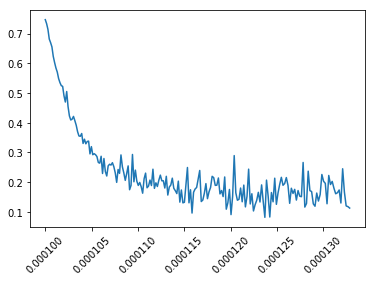

In [8]:
model = DenseNet121(14, pretrained=PRETRAINED, freeze=FREEZE).cuda()
lrs, losses  = lr_finder(model, 1, train_dl)

# Training definitions

In [ ]:
def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i


class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]

In [2]:
policy = TrainingPolicy(10, train_dl, max_lr=.01)


plt.subplot(1,2,0)
plt.plot(policy.lr_schedule)
plt.title("learning rate policy")

plt.subplot(1,2,1)
plt.plot(policy.lr_schedule)
plt.title("momentum policy")

NameError: name 'train_dl' is not defined

In [12]:
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training

In [16]:
# Whole dataset
freeze = True

transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
                       shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1663 -  val loss 0.1519 AUC 0.7481


A Jupyter Widget

Ep. 2 - train loss 0.1424 -  val loss 0.1477 AUC 0.7915


A Jupyter Widget

Ep. 3 - train loss 0.1389 -  val loss 0.1430 AUC 0.8061


A Jupyter Widget

Ep. 4 - train loss 0.1347 -  val loss 0.1455 AUC 0.8083


A Jupyter Widget

Ep. 5 - train loss 0.1308 -  val loss 0.1413 AUC 0.8180


A Jupyter Widget

Ep. 6 - train loss 0.1266 -  val loss 0.1407 AUC 0.8240


A Jupyter Widget

Ep. 7 - train loss 0.1222 -  val loss 0.1401 AUC 0.8246


A Jupyter Widget

Ep. 8 - train loss 0.1190 -  val loss 0.1408 AUC 0.8234


In [ ]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path, transforms = True, 
                      shuffle = False, data=data, batch_size = batch_size, normalize=pretrained)
TTA_multilabel(model, test_dl)

# Training script

In [8]:
%%writefile ../scripts/disease14_aprx2.py

import sys; sys.path.append("../../..")

from core import * 
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, TTA_multilabel


BATCH_SIZE = 16
EPOCHS = 50
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
DATA = '14diseases'

# (pretrained, freeze first blocks, prog_unfreezing)
METHODS = [(False, False, False), 
           (True, True, False), (True, False, False), (True, True, True),
           ('MURA', True, False), ('MURA', False, False), ('MURA', True, True)] 

RANDOM_STATES = range(10)
SAMPLE_AMOUNTS = [50,100,200,400,600,800,1000,1200,1400,1600,1800,2000]

BASE_PATH = Path('../../../../')
PATH = BASE_PATH/'data'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/models'
SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
IMG_FOLDER = PATH/'ChestXRay-250'


def train(n_epochs, train_dl, valid_dl, model, div_factor=25., max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss


train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

# train
for pretrained, freeze, grad_unfreeze in methods:
    
    valid_dl = DataBatches(valid_df,img_folder_path=IMG_FOLDER, transforms=False, 
                           shuffle=False, data=DATA, batch_size=BATCH_SIZE, normalize=pretrained)

    for rs in random_states:

        train_df = train_df.sample(frac=1)

        for N in n_samples:

            df = train_df[:N]

            train_dl = DataBatches(df, img_folder_path=IMG_FOLDER, transforms=transforms, shuffle=TRANSFORMATIONS,
                                   data=DATA, batch_size=BATCH_SIZE, normalize=pretrained)

            model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

            save_path = SAVE_DIRECTORY/f"app2_{pretrained}-{freeze}-{grad_unfreeze}-{N}-{rs}.pth"

            train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, unfreeze_during_loop=(.1, .2) if grad_unfreeze else None)
            


# evalutation
for pretrained, freeze, grad_unfreeze in methods:
    
    losses = [[] for _ in n_samples]
    aucs = [[] for _ in n_samples]
    
    test_dl = DataBatches(test_df, img_folder_path=IMG_FOLDER, transforms=TRANSFORMATIONS,
                          shuffle = False, data=DATA, batch_size=BATCH_SIZE, normalize=pretrained)
    
    for i, N in enumerate(n_samples):
        
        for rs in random_states:
            
            model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

            load_path = SAVE_DIRECTORY/f"app2_{pretrained}-{freeze}-{grad_unfreeze}-{N}-{rs}.pth"
            
            load_model(model, load_path)
            
            loss, mean_auc, _ = TTA_multilabel(model, test_dl, ndl=4)
            
            losses[i].append(loss)
            aucs[i].append(mean_auc)
    
    # save results
    loss_path = SAVE_DATA/f"losses_{pretrained}_{freeze}_{grad_unfreeze}"
    aucs_path = SAVE_DATA/f"aucs_{pretrained}_{freeze}_{grad_unfreeze}"
    
    numpy.save(loss_path, np.array(losses))
    numpy.save(aucs_path, np.array(aucs))

Overwriting disease14_aprx2.py
